# Bone Marrow Transplantation Survival Prediction

**Author:** Sebastian Hsiao  
**Date:** October 2025  
**Dataset:** Bone Marrow Transplantation (UCI Machine Learning Repository)

## Objective

Build an end-to-end scikit-learn pipeline to predict patient survival after bone marrow transplantation. The notebook demonstrates:

- Loading and exploring ARFF data
- Data cleaning and type conversion
- Exploratory Data Analysis (EDA)
- Column-specific preprocessing (categorical vs numeric)
- Dimensionality reduction with PCA
- Model training and evaluation
- Hyperparameter tuning with GridSearchCV
- Results interpretation and next steps

---
## 1. Setup and Imports

Import all necessary libraries for data manipulation, preprocessing, modeling, and visualization.

In [55]:
# Data manipulation
import numpy as np
import pandas as pd

# Scikit-learn: preprocessing and pipelines
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

# Evaluation
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score,
    roc_auc_score,
    roc_curve
)

# Data loading
from scipy.io import arff

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Config
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
np.random.seed(42)

print("✓ All imports successful")

✓ All imports successful


---
## 2. Load and Inspect Data

Load the ARFF dataset and perform initial inspection.

In [ ]:
# Load ARFF file
data = arff.loadarff('bone-marrow.arff')
df = pd.DataFrame(data[0])

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
df.head()

Dataset shape: (187, 37)

Columns: ['Recipientgender', 'Stemcellsource', 'Donorage', 'Donorage35', 'IIIV', 'Gendermatch', 'DonorABO', 'RecipientABO', 'RecipientRh', 'ABOmatch', 'CMVstatus', 'DonorCMV', 'RecipientCMV', 'Disease', 'Riskgroup', 'Txpostrelapse', 'Diseasegroup', 'HLAmatch', 'HLAmismatch', 'Antigen', 'Alel', 'HLAgrI', 'Recipientage', 'Recipientage10', 'Recipientageint', 'Relapse', 'aGvHDIIIIV', 'extcGvHD', 'CD34kgx10d6', 'CD3dCD34', 'CD3dkgx10d8', 'Rbodymass', 'ANCrecovery', 'PLTrecovery', 'time_to_aGvHD_III_IV', 'survival_time', 'survival_status']


,Recipientgender,Stemcellsource,Donorage,Donorage35,IIIV,Gendermatch,DonorABO,RecipientABO,RecipientRh,ABOmatch,...,extcGvHD,CD34kgx10d6,CD3dCD34,CD3dkgx10d8,Rbodymass,ANCrecovery,PLTrecovery,time_to_aGvHD_III_IV,survival_time,survival_status
0,b'1',b'1',22.830137,b'0',b'1',b'0',b'1',b'1',b'1',b'0',...,b'1',7.20,1.338760,5.38,35.0,19.0,51.0,32.0,999.0,0.0
1,b'1',b'0',23.342466,b'0',b'1',b'0',b'-1',b'-1',b'1',b'0',...,b'1',4.50,11.078295,0.41,20.6,16.0,37.0,1000000.0,163.0,1.0
2,b'1',b'0',26.394521,b'0',b'1',b'0',b'-1',b'-1',b'1',b'0',...,b'1',7.94,19.013230,0.42,23.4,23.0,20.0,1000000.0,435.0,1.0
3,b'0',b'0',39.684932,b'1',b'1',b'0',b'1',b'2',b'1',b'1',...,b'?',4.25,29.481647,0.14,50.0,23.0,29.0,19.0,53.0,1.0
4,b'0',b'1',33.358904,b'0',b'0',b'0',b'1',b'2',b'0',b'1',...,b'1',51.85,3.972255,13.05,9.0,14.0,14.0,1000000.0,2043.0,0.0


In [ ]:
# Display basic info
print("Dataset Info:")
df.info()
print("\n" + "="*60)
print("Summary Statistics:")
df.describe()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Recipientgender       187 non-null    object 
 1   Stemcellsource        187 non-null    object 
 2   Donorage              187 non-null    float64
 3   Donorage35            187 non-null    object 
 4   IIIV                  187 non-null    object 
 5   Gendermatch           187 non-null    object 
 6   DonorABO              187 non-null    object 
 7   RecipientABO          187 non-null    object 
 8   RecipientRh           187 non-null    object 
 9   ABOmatch              187 non-null    object 
 10  CMVstatus             187 non-null    object 
 11  DonorCMV              187 non-null    object 
 12  RecipientCMV          187 non-null    object 
 13  Disease               187 non-null    object 
 14  Riskgroup             187 non-null    object 
 15  Txpostrel

,Donorage,Recipientage,CD34kgx10d6,CD3dCD34,CD3dkgx10d8,Rbodymass,ANCrecovery,PLTrecovery,time_to_aGvHD_III_IV,survival_time,survival_status
count,187.000000,187.000000,187.000000,182.000000,182.000000,185.000000,187.000000,187.000000,187.000000,187.000000,187.000000
mean,33.472068,9.931551,11.891781,5.385096,4.745714,35.801081,26752.866310,90937.919786,775408.042781,938.743316,0.454545
std,8.271826,5.305639,9.914386,9.598716,3.859128,19.650922,161747.200525,288242.407688,418425.252689,849.589495,0.499266
min,18.646575,0.600000,0.790000,0.204132,0.040000,6.000000,9.000000,9.000000,10.000000,6.000000,0.000000
25%,27.039726,5.050000,5.350000,1.786683,1.687500,19.000000,13.000000,16.000000,1000000.000000,168.500000,0.000000
50%,33.550685,9.600000,9.720000,2.734462,4.325000,33.000000,15.000000,21.000000,1000000.000000,676.000000,0.000000
75%,40.117809,14.050000,15.415000,5.823565,6.785000,50.600000,17.000000,37.000000,1000000.000000,1604.000000,1.000000
max,55.553425,20.200000,57.780000,99.560970,20.020000,103.400000,1000000.000000,1000000.000000,1000000.000000,3364.000000,1.000000


---
## 3. Data Cleaning and Preprocessing

### 3.1 Remove Unnecessary Columns

Drop the `Disease` column as it's not needed for this analysis.

In [ ]:
# Drop Disease column
df.drop(columns=['Disease'], inplace=True)
print(f"Columns after dropping 'Disease': {list(df.columns)}")
print(f"New shape: {df.shape}")

Columns after dropping 'Disease': ['Recipientgender', 'Stemcellsource', 'Donorage', 'Donorage35', 'IIIV', 'Gendermatch', 'DonorABO', 'RecipientABO', 'RecipientRh', 'ABOmatch', 'CMVstatus', 'DonorCMV', 'RecipientCMV', 'Riskgroup', 'Txpostrelapse', 'Diseasegroup', 'HLAmatch', 'HLAmismatch', 'Antigen', 'Alel', 'HLAgrI', 'Recipientage', 'Recipientage10', 'Recipientageint', 'Relapse', 'aGvHDIIIIV', 'extcGvHD', 'CD34kgx10d6', 'CD3dCD34', 'CD3dkgx10d8', 'Rbodymass', 'ANCrecovery', 'PLTrecovery', 'time_to_aGvHD_III_IV', 'survival_time', 'survival_status']
New shape: (187, 36)


### 3.2 Type Conversion

Convert all columns to numeric, coercing errors to NaN values.

In [ ]:
# Convert all columns to numeric
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("✓ All columns converted to numeric")
print(f"\nData types after conversion:")
print(df.dtypes.value_counts())

✓ All columns converted to numeric

Data types after conversion:
float64    20
int64      16
Name: count, dtype: int64


### 3.3 Binary Column Encoding

Ensure binary columns are properly encoded as 0 and 1.

In [ ]:
# Encode binary columns as 0/1
binary_cols = df.columns[df.nunique() == 2]
print(f"Binary columns found: {list(binary_cols)}")

for col in binary_cols:
    df[col] = (df[col] == 1) * 1.0

print("✓ Binary columns encoded as 0/1")

Binary columns found: ['Recipientgender', 'Stemcellsource', 'Donorage35', 'IIIV', 'Gendermatch', 'RecipientRh', 'ABOmatch', 'DonorCMV', 'RecipientCMV', 'Riskgroup', 'Txpostrelapse', 'Diseasegroup', 'HLAmismatch', 'Recipientage10', 'Relapse', 'aGvHDIIIIV', 'extcGvHD', 'survival_status']
✓ Binary columns encoded as 0/1


---
## 4. Exploratory Data Analysis (EDA)

### 4.1 Feature Cardinality

Unique values per column:
                      unique_count
Donorage                       187
CD34kgx10d6                    183
CD3dCD34                       182
survival_time                  174
CD3dkgx10d8                    163
Rbodymass                      130
Recipientage                   125
PLTrecovery                     50
time_to_aGvHD_III_IV            28
ANCrecovery                     18
HLAgrI                           7
Alel                             5
HLAmatch                         4
Antigen                          4
CMVstatus                        4
RecipientABO                     4
DonorABO                         4
Recipientageint                  3
Recipientgender                  2
Stemcellsource                   2
Donorage35                       2
Riskgroup                        2
HLAmismatch                      2
Diseasegroup                     2
RecipientCMV                     2
RecipientRh                      2
ABOmatch                     

<Figure size 1200x600 with 0 Axes>

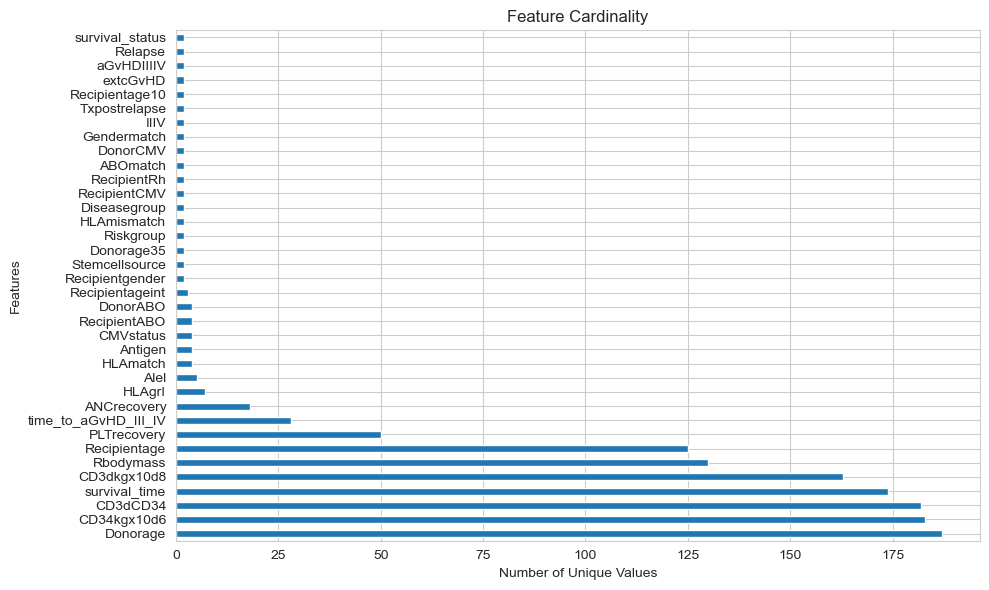

In [ ]:
# Count unique values per column
print("Unique values per column:")
print("=" * 60)
nunique_df = df.nunique().sort_values(ascending=False).to_frame('unique_count')
print(nunique_df)

# Visualize
plt.figure(figsize=(12, 6))
nunique_df.plot(kind='barh', legend=False)
plt.xlabel('Number of Unique Values')
plt.ylabel('Features')
plt.title('Feature Cardinality')
plt.tight_layout()
plt.show()

### 4.2 Missing Values Analysis

Missing Values Summary:
              Missing_Count  Missing_Percentage
CMVstatus                16            8.556150
CD3dkgx10d8               5            2.673797
CD3dCD34                  5            2.673797
Rbodymass                 2            1.069519
Alel                      1            0.534759
RecipientABO              1            0.534759
Antigen                   1            0.534759


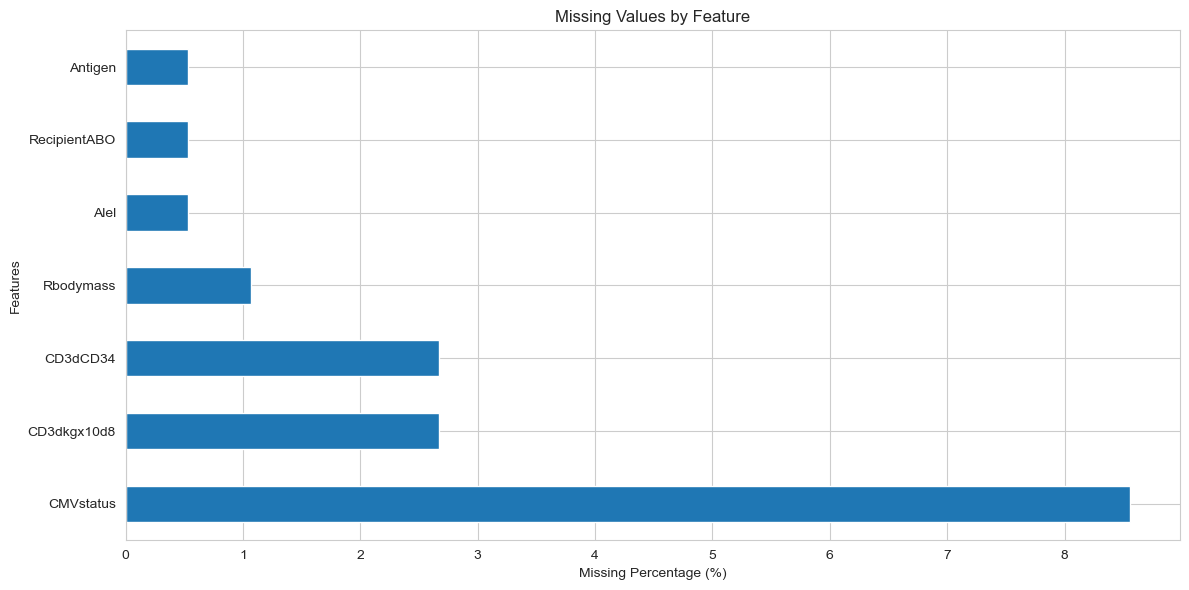

In [34]:
# Missing values summary
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Missing_Percentage': missing_pct
}).sort_values('Missing_Count', ascending=False)

print("Missing Values Summary:")
print("=" * 60)
print(missing_df[missing_df['Missing_Count'] > 0])

# Visualize missing values
if missing_df['Missing_Count'].sum() > 0:
    plt.figure(figsize=(12, 6))
    missing_df[missing_df['Missing_Count'] > 0]['Missing_Percentage'].plot(kind='barh')
    plt.xlabel('Missing Percentage (%)')
    plt.ylabel('Features')
    plt.title('Missing Values by Feature')
    plt.tight_layout()
    plt.show()

### 4.3 Target Variable Distribution

Target variable: survival_status
survival_status
0.0    102
1.0     85
Name: count, dtype: int64

Class balance:
survival_status
0.0    54.545455
1.0    45.454545
Name: proportion, dtype: float64


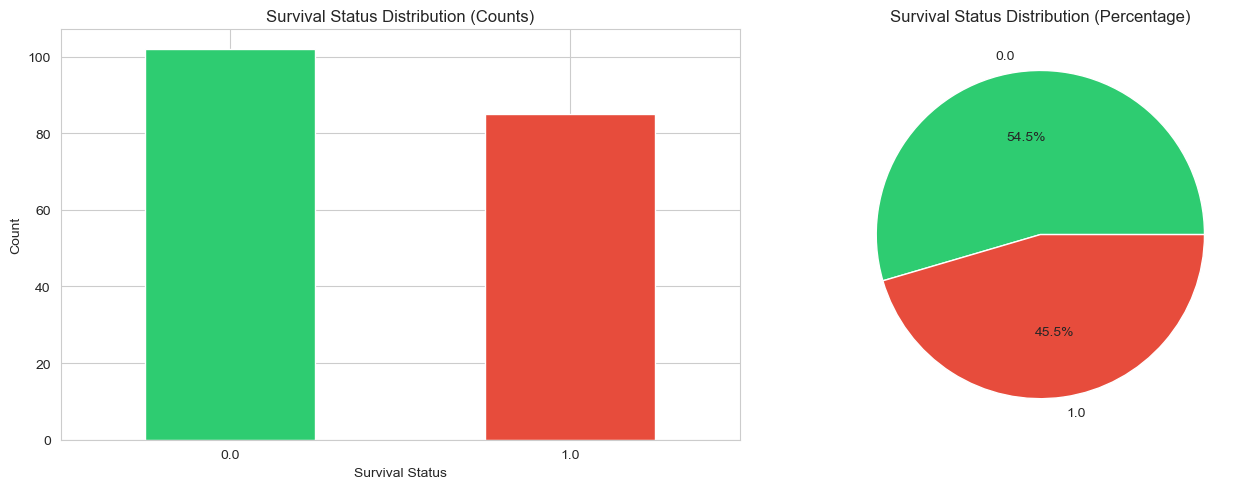

In [35]:
# Target distribution
target_col = 'survival_status'
print(f"Target variable: {target_col}")
print("=" * 60)
print(df[target_col].value_counts())
print(f"\nClass balance:")
print(df[target_col].value_counts(normalize=True) * 100)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df[target_col].value_counts().plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Survival Status Distribution (Counts)')
axes[0].set_xlabel('Survival Status')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

df[target_col].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', colors=['#2ecc71', '#e74c3c'])
axes[1].set_title('Survival Status Distribution (Percentage)')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

---
## 5. Feature and Target Split

Separate features (X) and target (y). We drop `survival_time` as it's not a predictor.

In [36]:
# Define target and features
y = df['survival_status']
X = df.drop(columns=['survival_status', 'survival_time'])

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns ({len(X.columns)}):")
print(list(X.columns))

Features shape: (187, 34)
Target shape: (187,)

Feature columns (34):
['Recipientgender', 'Stemcellsource', 'Donorage', 'Donorage35', 'IIIV', 'Gendermatch', 'DonorABO', 'RecipientABO', 'RecipientRh', 'ABOmatch', 'CMVstatus', 'DonorCMV', 'RecipientCMV', 'Riskgroup', 'Txpostrelapse', 'Diseasegroup', 'HLAmatch', 'HLAmismatch', 'Antigen', 'Alel', 'HLAgrI', 'Recipientage', 'Recipientage10', 'Recipientageint', 'Relapse', 'aGvHDIIIIV', 'extcGvHD', 'CD34kgx10d6', 'CD3dCD34', 'CD3dkgx10d8', 'Rbodymass', 'ANCrecovery', 'PLTrecovery', 'time_to_aGvHD_III_IV']


### 5.1 Identify Categorical vs Numerical Features

Based on cardinality (≤7 unique values → categorical, >7 → numerical).

In [37]:
# Define categorical and numerical columns based on unique value count
CARDINALITY_THRESHOLD = 7
num_cols = X.columns[X.nunique() > CARDINALITY_THRESHOLD].tolist()
cat_cols = X.columns[X.nunique() <= CARDINALITY_THRESHOLD].tolist()

print(f"Numerical features ({len(num_cols)}):")
print(num_cols)
print(f"\nCategorical features ({len(cat_cols)}):")
print(cat_cols)

Numerical features (9):
['Donorage', 'Recipientage', 'CD34kgx10d6', 'CD3dCD34', 'CD3dkgx10d8', 'Rbodymass', 'ANCrecovery', 'PLTrecovery', 'time_to_aGvHD_III_IV']

Categorical features (25):
['Recipientgender', 'Stemcellsource', 'Donorage35', 'IIIV', 'Gendermatch', 'DonorABO', 'RecipientABO', 'RecipientRh', 'ABOmatch', 'CMVstatus', 'DonorCMV', 'RecipientCMV', 'Riskgroup', 'Txpostrelapse', 'Diseasegroup', 'HLAmatch', 'HLAmismatch', 'Antigen', 'Alel', 'HLAgrI', 'Recipientage10', 'Recipientageint', 'Relapse', 'aGvHDIIIIV', 'extcGvHD']


---
## 6. Train-Test Split

Split data into training (80%) and test (20%) sets with stratification.

In [38]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nClass distribution in training set:")
print(y_train.value_counts(normalize=True) * 100)
print(f"\nClass distribution in test set:")
print(y_test.value_counts(normalize=True) * 100)

Training set: (149, 34)
Test set: (38, 34)

Class distribution in training set:
survival_status
0.0    54.362416
1.0    45.637584
Name: proportion, dtype: float64

Class distribution in test set:
survival_status
0.0    55.263158
1.0    44.736842
Name: proportion, dtype: float64


---
## 7. Build Preprocessing Pipeline

Create separate preprocessing pipelines for categorical and numerical features.

### 7.1 Categorical Pipeline
- Impute missing values with most frequent value (mode)
- One-Hot Encode with `drop='first'` to avoid multicollinearity

### 7.2 Numerical Pipeline
- Impute missing values with mean
- Standardize features (zero mean, unit variance)

In [39]:
# Categorical preprocessing pipeline
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'))
])

# Numerical preprocessing pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combine with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_pipeline, cat_cols),
        ('num', num_pipeline, num_cols)
    ],
    verbose_feature_names_out=False
)

print("✓ Preprocessing pipeline created")
print(f"  - Categorical features: {len(cat_cols)}")
print(f"  - Numerical features: {len(num_cols)}")

✓ Preprocessing pipeline created
  - Categorical features: 25
  - Numerical features: 9


---
## 8. Build Full ML Pipeline

Combine preprocessing, dimensionality reduction (PCA), and classification (Logistic Regression) into a single pipeline.

In [40]:
# Create full pipeline
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('pca', PCA()),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

print("✓ Full pipeline created")
print("\nPipeline steps:")
for idx, (name, step) in enumerate(pipeline.steps, 1):
    print(f"  {idx}. {name}: {type(step).__name__}")

✓ Full pipeline created

Pipeline steps:
  1. preprocess: ColumnTransformer
  2. pca: PCA
  3. clf: LogisticRegression


---
## 9. Train Baseline Model

Train the pipeline with default parameters to establish a baseline.

In [41]:
# Fit the pipeline
print("Training baseline model...")
pipeline.fit(X_train, y_train)

# Evaluate on train and test sets
train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

print(f"\n{'='*60}")
print("BASELINE MODEL PERFORMANCE")
print(f"{'='*60}")
print(f"Training Accuracy: {train_score:.4f}")
print(f"Test Accuracy:     {test_score:.4f}")
print(f"{'='*60}")

Training baseline model...

BASELINE MODEL PERFORMANCE
Training Accuracy: 0.8926
Test Accuracy:     0.5789


### 9.1 Baseline Model Evaluation

Classification Report (Baseline):
              precision    recall  f1-score   support

         0.0       0.60      0.71      0.65        21
         1.0       0.54      0.41      0.47        17

    accuracy                           0.58        38
   macro avg       0.57      0.56      0.56        38
weighted avg       0.57      0.58      0.57        38



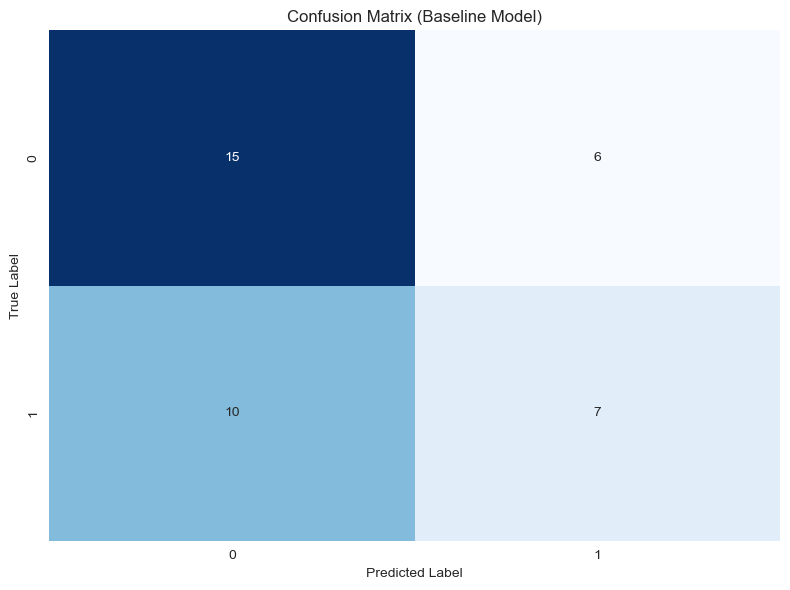

In [42]:
# Predictions
y_pred_baseline = pipeline.predict(X_test)
y_pred_proba_baseline = pipeline.predict_proba(X_test)[:, 1]

# Classification report
print("Classification Report (Baseline):")
print("=" * 60)
print(classification_report(y_test, y_pred_baseline))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_baseline)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Baseline Model)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

---
## 10. Hyperparameter Tuning with GridSearchCV

Optimize:
- `pca__n_components`: Number of principal components
- `clf__C`: Regularization strength for Logistic Regression

In [43]:
# Define hyperparameter search space
param_grid = {
    'pca__n_components': np.linspace(30, 37, 3).astype(int),
    'clf__C': np.logspace(-4, 2, 10)
}

print("Hyperparameter Search Space:")
print("=" * 60)
for param, values in param_grid.items():
    print(f"{param}: {values}")

# Initialize GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print(f"\nTotal combinations to test: {len(param_grid['pca__n_components']) * len(param_grid['clf__C'])}")
print(f"Cross-validation folds: 5")
print(f"Total fits: {len(param_grid['pca__n_components']) * len(param_grid['clf__C']) * 5}")

Hyperparameter Search Space:
pca__n_components: [30 33 37]
clf__C: [1.00000000e-04 4.64158883e-04 2.15443469e-03 1.00000000e-02
 4.64158883e-02 2.15443469e-01 1.00000000e+00 4.64158883e+00
 2.15443469e+01 1.00000000e+02]

Total combinations to test: 30
Cross-validation folds: 5
Total fits: 150


In [44]:
# Run grid search
print("\nRunning GridSearchCV...")
print("This may take a few moments...\n")
grid_search.fit(X_train, y_train)
print("\n✓ Grid search complete!")


Running GridSearchCV...
This may take a few moments...

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/opt/miniconda3/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/miniconda3/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/miniconda3/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _Forkin


✓ Grid search complete!


/opt/miniconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### 10.1 Best Model Results

In [45]:
# Extract best model
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_cv_score = grid_search.best_score_

print(f"{'='*60}")
print("BEST MODEL (after GridSearchCV)")
print(f"{'='*60}")
print(f"\nBest Parameters:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

print(f"\nBest Cross-Validation Score: {best_cv_score:.4f}")
print(f"\nClassifier: {type(best_model.named_steps['clf']).__name__}")
print(f"PCA Components: {best_model.named_steps['pca'].n_components}")
print(f"{'='*60}")

BEST MODEL (after GridSearchCV)

Best Parameters:
  clf__C: 4.641588833612772
  pca__n_components: 37

Best Cross-Validation Score: 0.7995

Classifier: LogisticRegression
PCA Components: 37


### 10.2 Evaluate Best Model on Test Set

In [46]:
# Test set performance
best_train_score = best_model.score(X_train, y_train)
best_test_score = best_model.score(X_test, y_test)

print(f"{'='*60}")
print("BEST MODEL PERFORMANCE")
print(f"{'='*60}")
print(f"Training Accuracy: {best_train_score:.4f}")
print(f"Test Accuracy:     {best_test_score:.4f}")
print(f"\nImprovement over baseline: {(best_test_score - test_score)*100:.2f}%")
print(f"{'='*60}")

BEST MODEL PERFORMANCE
Training Accuracy: 0.9195
Test Accuracy:     0.6316

Improvement over baseline: 5.26%


Classification Report (Best Model):
              precision    recall  f1-score   support

         0.0       0.65      0.71      0.68        21
         1.0       0.60      0.53      0.56        17

    accuracy                           0.63        38
   macro avg       0.63      0.62      0.62        38
weighted avg       0.63      0.63      0.63        38



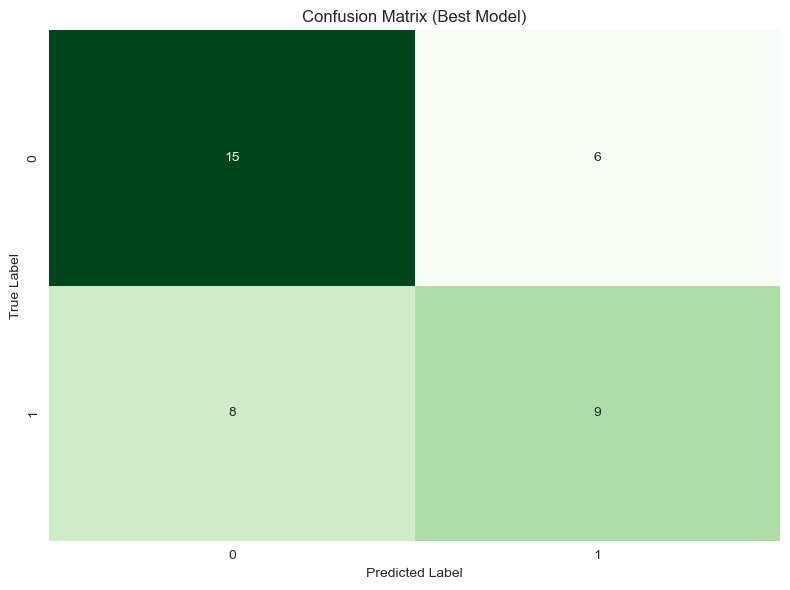

In [47]:
# Detailed evaluation
y_pred_best = best_model.predict(X_test)
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

print("Classification Report (Best Model):")
print("=" * 60)
print(classification_report(y_test, y_pred_best))

# Confusion matrix
cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Confusion Matrix (Best Model)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### 10.3 ROC Curve

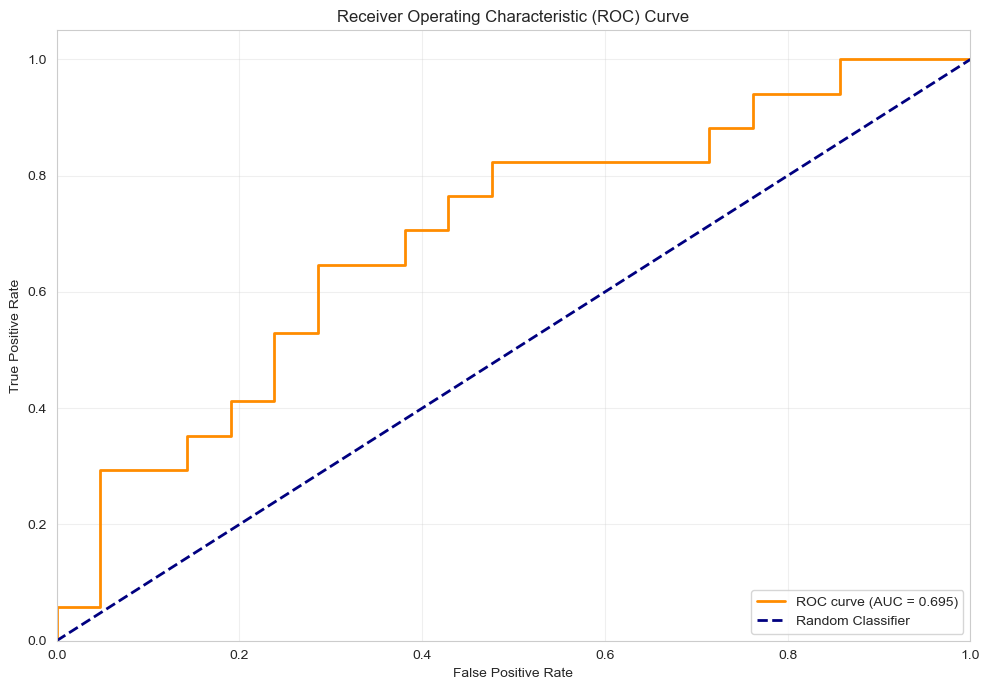

ROC AUC Score: 0.6947


In [48]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_best)
roc_auc = roc_auc_score(y_test, y_pred_proba_best)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")

---
## 11. Model Interpretation

### 11.1 Explained Variance by PCA

Number of components: 37
Total variance explained: 0.9938


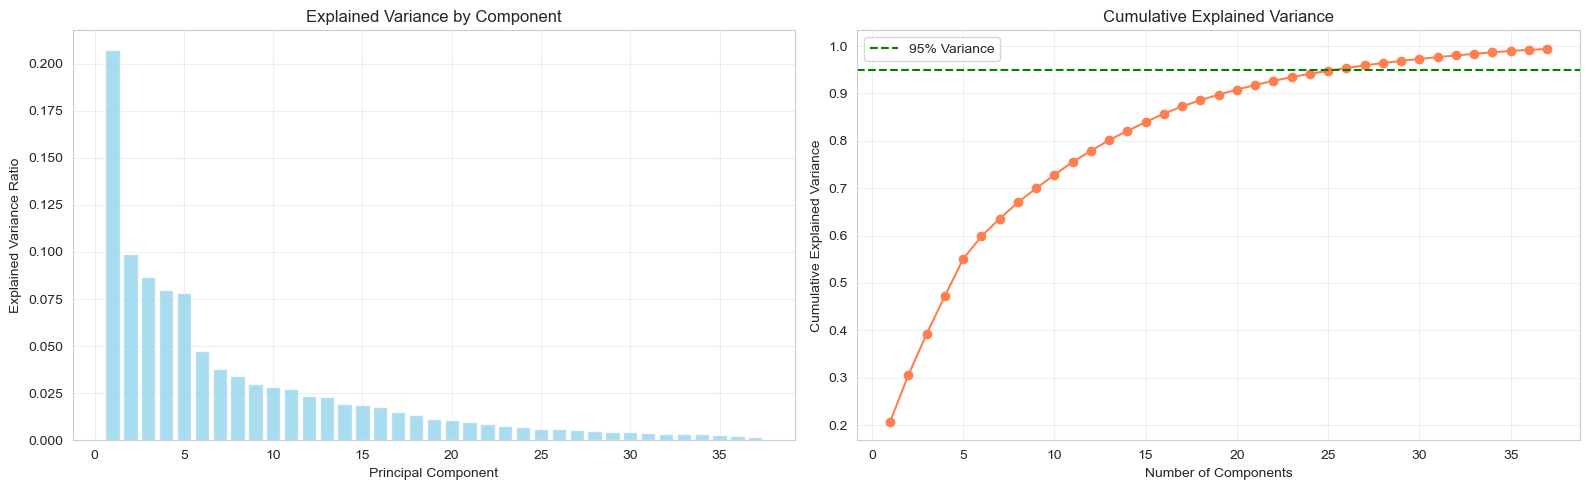

In [49]:
# PCA explained variance
pca_model = best_model.named_steps['pca']
explained_variance = pca_model.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print(f"Number of components: {len(explained_variance)}")
print(f"Total variance explained: {cumulative_variance[-1]:.4f}")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Individual variance
axes[0].bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, color='skyblue')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Explained Variance by Component')
axes[0].grid(alpha=0.3)

# Cumulative variance
axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='coral')
axes[1].axhline(y=0.95, color='green', linestyle='--', label='95% Variance')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Explained Variance')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 11.2 Feature Importance (Logistic Regression Coefficients)

Note: Coefficients are on PCA-transformed features, not original features.

Top 10 Most Important Principal Components:
Feature  Coefficient  Abs_Coefficient
   PC27     3.525998         3.525998
   PC25     2.464217         2.464217
   PC35    -2.245599         2.245599
   PC24     2.203229         2.203229
   PC18     1.997238         1.997238
   PC34     1.971134         1.971134
   PC32    -1.707430         1.707430
    PC2     1.443303         1.443303
   PC26     1.377585         1.377585
   PC37     1.281388         1.281388


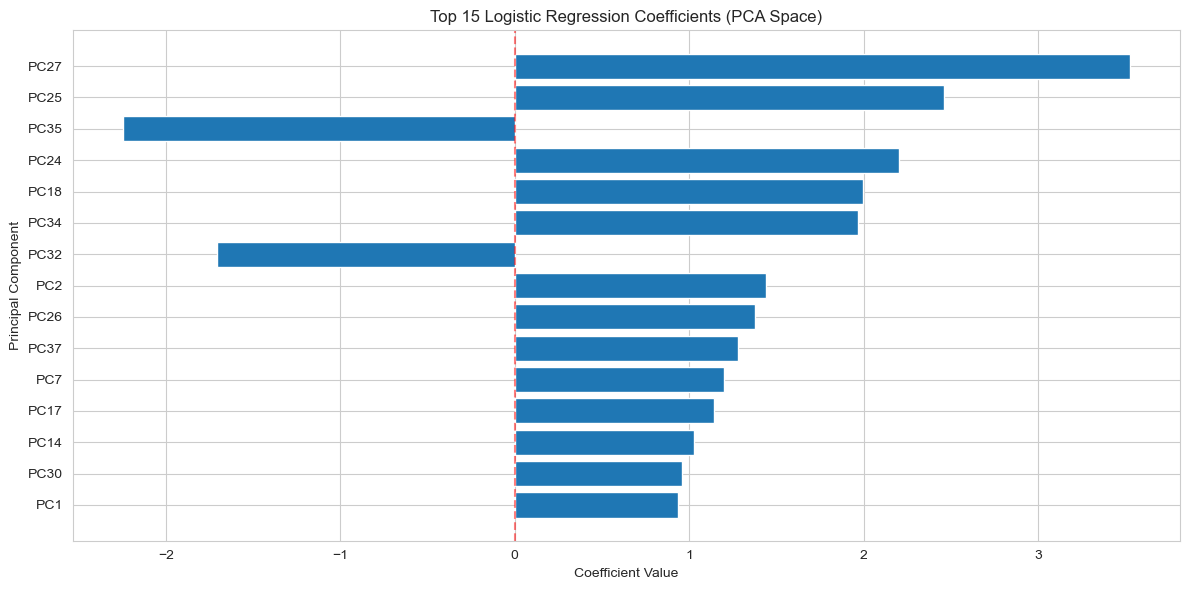

In [50]:
# Get coefficients
clf_model = best_model.named_steps['clf']
coefficients = clf_model.coef_[0]

# Create feature names
feature_names = [f'PC{i+1}' for i in range(len(coefficients))]
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=False)

print("Top 10 Most Important Principal Components:")
print("=" * 60)
print(coef_df.head(10).to_string(index=False))

# Plot
plt.figure(figsize=(12, 6))
plt.barh(coef_df['Feature'][:15], coef_df['Coefficient'][:15])
plt.xlabel('Coefficient Value')
plt.ylabel('Principal Component')
plt.title('Top 15 Logistic Regression Coefficients (PCA Space)')
plt.axvline(x=0, color='red', linestyle='--', alpha=0.5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

---
## 12. Model Comparison Summary


Model Comparison:
              Model  Train Accuracy  Test Accuracy  PCA Components  C (Regularization)
 Baseline (Default)        0.892617       0.578947              53            1.000000
Best (GridSearchCV)        0.919463       0.631579              37            4.641589


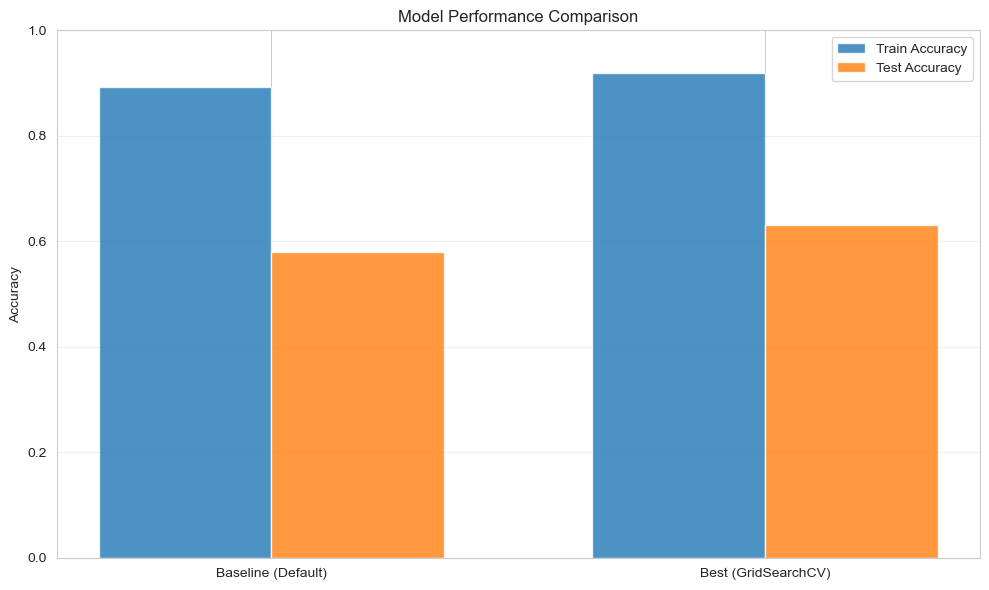

In [51]:
# Create comparison table
comparison = pd.DataFrame({
    'Model': ['Baseline (Default)', 'Best (GridSearchCV)'],
    'Train Accuracy': [train_score, best_train_score],
    'Test Accuracy': [test_score, best_test_score],
    'PCA Components': [pipeline.named_steps['pca'].n_components_, 
                       best_model.named_steps['pca'].n_components],
    'C (Regularization)': [pipeline.named_steps['clf'].C, 
                          best_model.named_steps['clf'].C]
})

print("\nModel Comparison:")
print("=" * 80)
print(comparison.to_string(index=False))
print("=" * 80)

# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(comparison))
width = 0.35

ax.bar(x - width/2, comparison['Train Accuracy'], width, label='Train Accuracy', alpha=0.8)
ax.bar(x + width/2, comparison['Test Accuracy'], width, label='Test Accuracy', alpha=0.8)

ax.set_ylabel('Accuracy')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(comparison['Model'])
ax.legend()
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

---
## 13. Save Best Model (Optional)

Persist the best model for future use.

In [52]:
import joblib
from pathlib import Path

# Create models directory
models_dir = Path('models')
models_dir.mkdir(exist_ok=True)

# Save model
model_path = models_dir / 'best_bone_marrow_model.joblib'
joblib.dump(best_model, model_path)
print(f"✓ Model saved to: {model_path}")

# Save metadata
metadata = {
    'test_accuracy': best_test_score,
    'train_accuracy': best_train_score,
    'best_params': best_params,
    'cv_score': best_cv_score,
    'roc_auc': roc_auc,
    'n_features': X.shape[1],
    'n_samples_train': len(X_train),
    'n_samples_test': len(X_test)
}

import json
metadata_path = models_dir / 'model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✓ Metadata saved to: {metadata_path}")

✓ Model saved to: models/best_bone_marrow_model.joblib


TypeError: Object of type int64 is not JSON serializable

---
## 14. Conclusions and Next Steps

### Summary

- **Dataset**: Bone marrow transplantation with survival prediction
- **Preprocessing**: Separate pipelines for categorical (mode imputation + OHE) and numerical (mean imputation + scaling)
- **Dimensionality Reduction**: PCA to reduce feature space
- **Model**: Logistic Regression with L2 regularization
- **Tuning**: GridSearchCV with 5-fold cross-validation
- **Best Test Accuracy**: {:.4f}
- **ROC AUC**: {:.4f}

### Next Steps

1. **Try alternative models**: Random Forest, Gradient Boosting (XGBoost, LightGBM), SVM
2. **Feature engineering**: Create interaction terms, polynomial features
3. **Handle class imbalance**: SMOTE, class weights, threshold tuning
4. **Expand hyperparameter search**: Include more PCA components, try different regularization types
5. **Cross-validation strategies**: Stratified K-Fold, Repeated K-Fold
6. **Feature selection**: SelectKBest, Recursive Feature Elimination (RFE)
7. **Ensemble methods**: Stacking, voting classifiers
8. **Deploy model**: Create inference API or batch prediction script
9. **Monitor performance**: Track predictions on new data, retrain periodically

### References

- [UCI ML Repository - Bone Marrow Transplant Dataset](https://archive.ics.uci.edu/)
- [Scikit-learn Documentation](https://scikit-learn.org/)
- [Pipeline Best Practices](https://scikit-learn.org/stable/modules/compose.html)

---
**End of Notebook**